In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb


import os
import warnings

from pathlib import Path

#Configurations
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

## Directories and Filenames
Contains paths and filenames to access test and training data.

In [115]:
ROOT_DIR = Path.cwd().parent
SRC_DIR = os.path.join(ROOT_DIR, 'src')
DATA_DIR = os.path.join(ROOT_DIR, 'data')

processed_training_data_path = os.path.join(DATA_DIR, 'train_processed.csv')
processed_test_data_path = os.path.join(DATA_DIR, 'test_processed.csv')

In [116]:
df_train = pd.read_csv(processed_training_data_path)
df_unseen_test = pd.read_csv(processed_test_data_path)

In [117]:
x7_cols = [col for col in df_train.columns if col.startswith('x7_')]

df_train_polka = df_train[df_train['x7_Polka'] == 1]
df_train_polka = df_train_polka.drop(x7_cols, axis=1)

# df_train_slängpolskor = df_train[df_train['x7_Slängpolskor'] == 1]
# df_train_slängpolskor = df_train_slängpolskor.drop(x7_cols, axis=1)

df_train_schottis = df_train[df_train['x7_Schottis'] == 1]
df_train_schottis = df_train_schottis.drop(x7_cols, axis=1)

df_train_polskor = df_train[(df_train['x7_Polskor'] == 1) | (df_train['x7_Slängpolskor'] == 1)]
df_train_polskor = df_train_polskor.drop(x7_cols, axis=1)

df_train_hambo = df_train[df_train['x7_Hambo'] == 1]
df_train_hambo = df_train_hambo.drop(x7_cols, axis=1)

df_train_x12_1 = df_train[df_train['x12_True'] == 1]
df_train_x12_1 = df_train_x12_1.drop('x12_True', axis=1)

df_train_x12_0 = df_train[df_train['x12_True'] == 0]
df_train_x12_0 = df_train_x12_0.drop('x12_True', axis=1)

## Train, Validation and Test Splits & Modeling

In [118]:
df_test = df_train.sample(frac=0.2, random_state=42)
df_train = df_train.drop(df_test.index)

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"Unseen test shape: {df_unseen_test.shape}")

df_train.head()

Train shape: (790, 16)
Test shape: (197, 16)
Unseen test shape: (10000, 17)


,x7_Hambo,x7_Polka,x7_Polskor,x7_Schottis,x7_Slängpolskor,x12_True,x1,x3,x4,x5,x6,x8,x9,x10,x11,y
0,0.0,0.0,0.0,0.0,1.0,1.0,-0.217610,-1.172690,0.041297,0.168716,0.987879,1.243974,0.323734,-0.275316,-0.462594,2
1,1.0,0.0,0.0,0.0,0.0,1.0,-1.723374,0.639590,0.505788,-0.394709,0.235030,-0.343594,-0.401810,-0.042394,0.763768,0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.815268,1.466614,0.476071,-0.055452,-0.279269,0.888450,0.078986,-1.363136,-0.845952,1
3,0.0,0.0,0.0,0.0,1.0,1.0,-0.456902,0.383763,0.279145,-0.166733,1.651127,-0.935800,-0.617531,0.041439,-0.285398,2
4,0.0,0.0,0.0,1.0,0.0,1.0,0.878887,-0.539423,0.952232,-1.010925,-1.574866,-1.471067,1.137805,0.408868,-0.852787,1


In [119]:
def train_different_models(x_train, y_train):
    
    from sklearn.model_selection import GridSearchCV

    xgb_model = xgb.XGBClassifier(objective='multi:softmax', random_state=42, n_jobs=-1)
    parameters = {
        'n_estimators': [30, 50, 70, 100, 200, 300],
        'max_depth': [3, 5, 7, 8, 10, 15],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
    }

    #Define custom scoring function according to weighted f1 score for each class
    from sklearn.metrics import f1_score, make_scorer

    def weighted_f1_score(y_true, y_pred):
        return f1_score(y_true, y_pred, average='weighted')

    scoring = make_scorer(weighted_f1_score, greater_is_better=True)

    xgb_cv = GridSearchCV(xgb_model, parameters, cv=10, n_jobs=-1, scoring=scoring)
    xgb_cv.fit(x_train, y_train)

    return xgb_cv

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, f1_score

def evaluate_model(model_predictions, model_labels, model):
    fig, ax = plt.subplots(figsize=(12, 8))
    cm = confusion_matrix(model_labels, model_predictions)
    cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    cmp.plot(ax=ax)
    plt.show()

    #print(classification_report(model_labels, model_predictions))
    print(f"Weighted F1 Score across all classes: {f1_score(model_labels, model_predictions, average='weighted')}")
    return f1_score(model_labels, model_predictions, average='weighted')

def train_and_evaluate_different_models_for_splits(dataframes, labels):
    xgb_models = {}
    f1_scores_xgb = {}
    sample_sizes = []

    for name, df in zip(labels, dataframes):
        x_train, x_val, y_train, y_val = train_test_split(df.drop(['y'], axis=1), df['y'], test_size=0.2, random_state=42, stratify=df['y'])
        print(f"Train shape before SMOTE: {x_train.shape}")

        x_train, y_train = upsample_training_data_with_SMOTE(x_train, y_train)

        print(f"Train shape after SMOTE: {x_train.shape}")

        sample_sizes.append(x_train.shape[0])

        xgb_model = train_different_models(x_train, y_train)
        xgb_models[f"{name}_xgb"] = xgb_model

        xgb_predictions = xgb_model.predict(x_val)

        f1_scores_xgb[f"{name}_xgb"] = evaluate_model(xgb_predictions, y_val, xgb_model)
    
    
    weights = sample_sizes / np.sum(sample_sizes)
    print(f" Weighted overall f1_scores_xgb: {weights.dot(list(f1_scores_xgb.values())).mean()}")

    return xgb_models, f1_scores_xgb

def upsample_training_data_with_SMOTE(x_train, y_train):
    from imblearn.over_sampling import SMOTE

    sm = SMOTE(random_state=42, n_jobs=-1)
    x_train, y_train = sm.fit_resample(x_train, y_train)

    return x_train, y_train



y
2    83
1    39
0    35
Name: count, dtype: int64

Train shape before SMOTE: (201, 10)
Train shape after SMOTE: (321, 10)


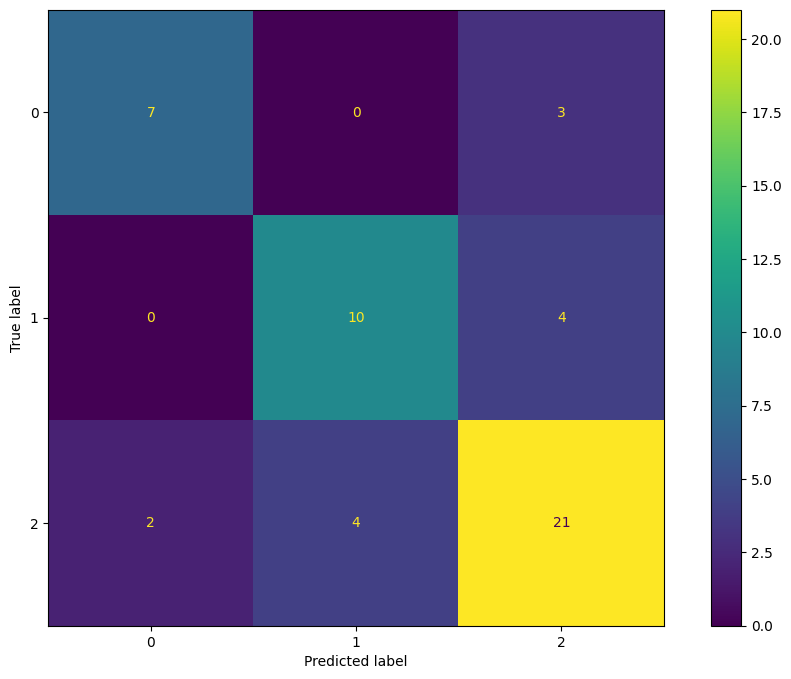

Weighted F1 Score across all classes: 0.7448353504081059
Train shape before SMOTE: (125, 10)
Train shape after SMOTE: (198, 10)


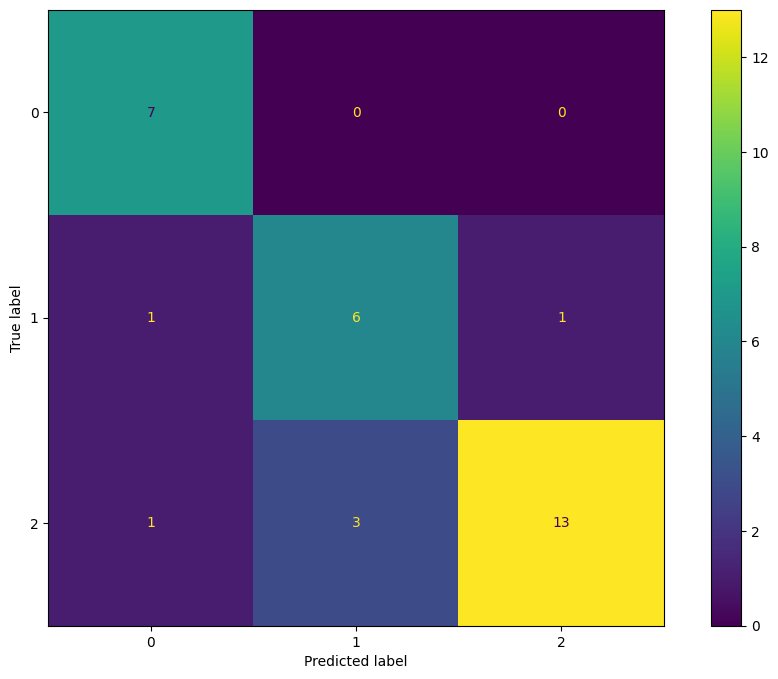

Weighted F1 Score across all classes: 0.8134413543643264
Train shape before SMOTE: (278, 10)
Train shape after SMOTE: (432, 10)


In [121]:
#Train and evaluate separate models
data_by_x5 = [df_train_polka, df_train_schottis, df_train_polskor, df_train_hambo]

labels = ['Polka', 'Schottis', 'Polskor', 'Hambo']

xgb_models, f1_xgb = train_and_evaluate_different_models_for_splits(data_by_x5, labels)
f1_xgb

Train shape: (608, 14)
Train shape: (608,)
best model score: 0.8397927938496885
best model score: 0.8448571567973083


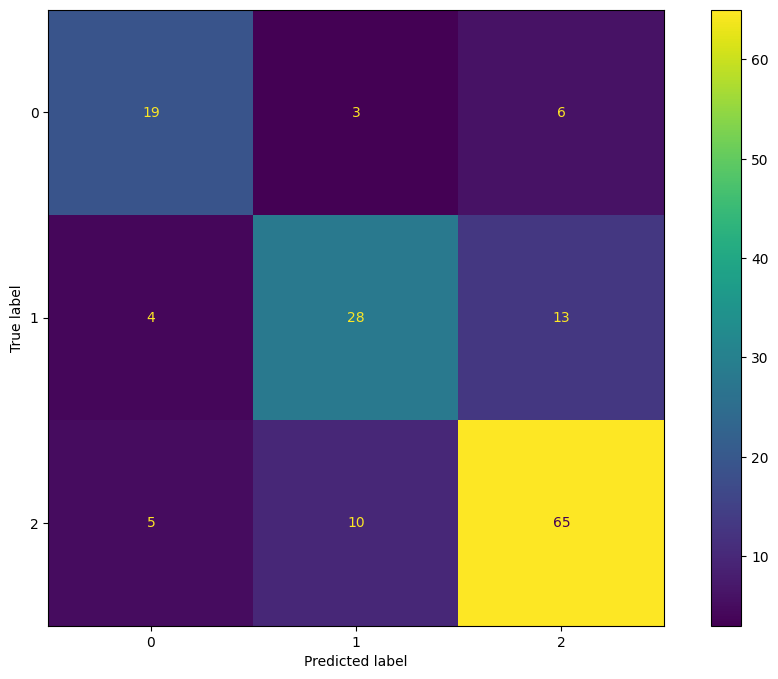

Weighted F1 Score across all classes: 0.7301762073708289
Train shape: (180, 14)
Train shape: (180,)
best model score: 0.8501955232595059
best model score: 0.8397347286846035


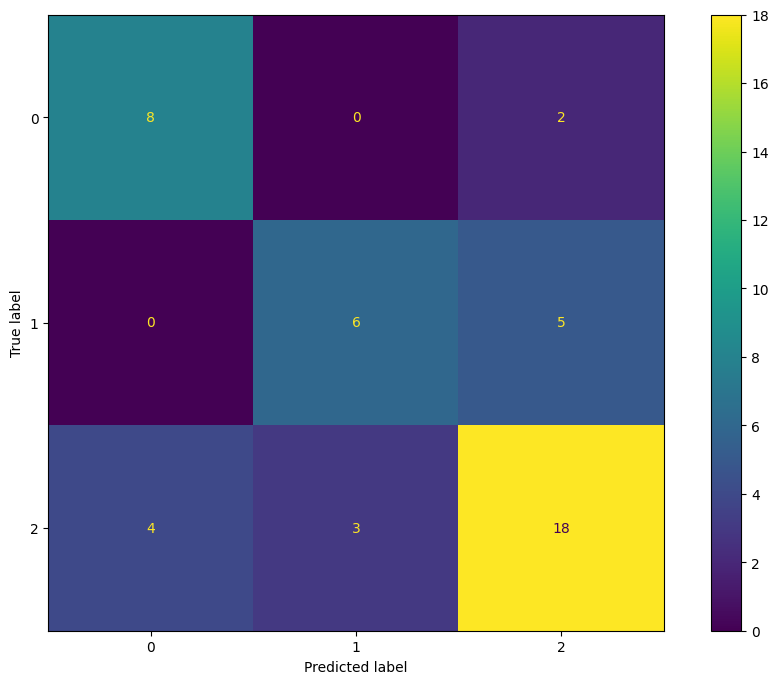

Weighted F1 Score across all classes: 0.6928853754940711
 Weighted overall f1_scores_xgb: 0.7214809893611042


In [ ]:
x12_dfs = [df_train_x12_1, df_train_x12_0]
x12_labels = ['x12_True', 'x12_False']

xgb_models_x12 = train_and_evaluate_different_models_for_splits(x12_dfs, x12_labels)

Train shape: (632, 15)
Train shape: (632,)
best model score: 0.8589951026765364
best model score: 0.8539709760755205


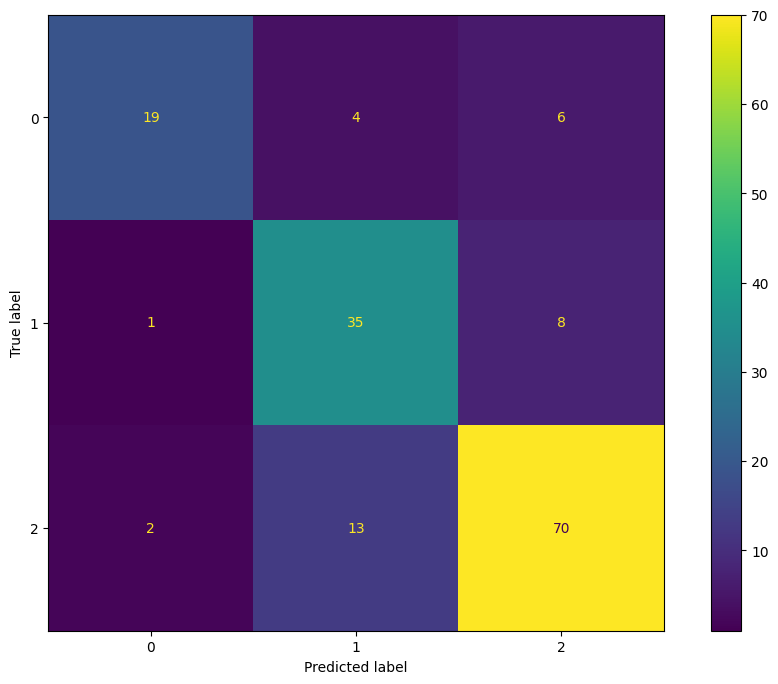

Weighted F1 Score across all classes: 0.7854770737596214
 Weighted overall f1_scores_xgb: 0.7854770737596214


({'All_xgb': GridSearchCV(cv=10,
               estimator=XGBClassifier(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bynode=None,
                                       colsample_bytree=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False, eval_metric=None,
                                       feature_types=None, gamma=None,
                                       gpu_id=None, grow_policy=None,
                                       importance_type=None,
                                       interaction_constraints=None,
                                       learning_rate=None...
                                       max_cat_threshold=None,
                                       max_cat_to_onehot=None,
                                       max_delta_step=None, max_depth=None,
          

In [ ]:
train_and_evaluate_different_models_for_splits([df_train], ['All'])

## Model Evaluation

Evaluating random forest multiclass classifier and xgboost multiclass classifier according to predictions made by the best estimator obtained in f1 score scored grid search. 